In [11]:
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
import nibabel as nib
import numpy as np
import os
from sklearn.model_selection import train_test_split
import cv2
import torch
import torch.nn.functional as F

import matplotlib
import matplotlib.pyplot as plt
from skimage.transform import rotate
from skimage.util import montage

In [12]:
TRAINING_DATA_PATH = "../BrainTumourData/imagesTr/"
TRAINING_SEGMENTATION_PATH = "../BrainTumourData/labelsTr/"

IMG_SIZE = 128

In [13]:
class BrainTumourDataset(Dataset):
    def __init__(
        self,
        file_ids,
        img_dim=(IMG_SIZE, IMG_SIZE),
        transform=None,
    ):
        self.dim = img_dim
        self.file_ids = file_ids
        self.transform = transform
        self.n_channels = 2

    def __len__(self):
        return len(self.file_ids)

    def __getitem__(self, idx):
        file_id = self.file_ids[idx]
        X, y = self.__data_generation(file_id)
        return X, y

    def __data_generation(self, file_id):

        data_path = os.path.join(TRAINING_DATA_PATH, file_id)
        seg_path = os.path.join(TRAINING_SEGMENTATION_PATH, file_id)

        data = nib.load(data_path).get_fdata()
        seg = nib.load(seg_path).get_fdata()

        num_slices = data.shape[2]

        X = np.zeros((num_slices, *self.dim, self.n_channels), dtype=np.float32)
        y = np.zeros((num_slices, *self.dim), dtype=np.float32)

        flair = data[:, :, :, 0]
        t1w = data[:, :, :, 1]

        for i in range(num_slices):
            X[i, :, :, 0] = cv2.resize(flair[:, :, i], self.dim)
            X[i, :, :, 1] = cv2.resize(t1w[:, :, i], self.dim)

            y[i] = cv2.resize(
                seg[:, :, i],
                self.dim,
                interpolation=cv2.INTER_NEAREST,
            )

        y_tensor = torch.from_numpy(y).long()  # Convert to tensor with long type
        Y = F.one_hot(y_tensor, num_classes=4).permute(0, 3, 1, 2).float()
        X = X / np.max(X)
        return X, Y


class BrainTumourDataModule(pl.LightningDataModule):
    def __init__(
        self,
        dir_path,
        batch_size=1,
        num_workers=4,
        img_dim=(IMG_SIZE, IMG_SIZE),
        transform=None,
    ):
        super().__init__()
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.img_dim = img_dim
        self.transform = transform
        self.train_ids = self.val_ids = self.test_ids = None

    def prepare_data(self):
        self.training_datas = [f.name for f in os.scandir(self.dir_path) if f.is_file()]

    def setup(self, stage=None):
        train_test_ids, val_ids = train_test_split(self.training_datas, test_size=0.2)
        train_ids, test_ids = train_test_split(train_test_ids, test_size=0.15)

        self.train_ids = train_ids
        self.val_ids = val_ids
        self.test_ids = test_ids

        # Create datasets for each split
        self.train_dataset = BrainTumourDataset(
            self.train_ids,
            img_dim=self.img_dim,
            transform=self.transform,
        )
        self.val_dataset = BrainTumourDataset(
            self.val_ids,
            img_dim=self.img_dim,
            transform=self.transform,
        )
        self.test_dataset = BrainTumourDataset(
            self.test_ids,
            img_dim=self.img_dim,
            transform=self.transform,
        )

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset, batch_size=self.batch_size, num_workers=self.num_workers
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset, batch_size=self.batch_size, num_workers=self.num_workers
        )

In [14]:
data_module = BrainTumourDataModule(TRAINING_DATA_PATH)
data_module.prepare_data()
data_module.setup()

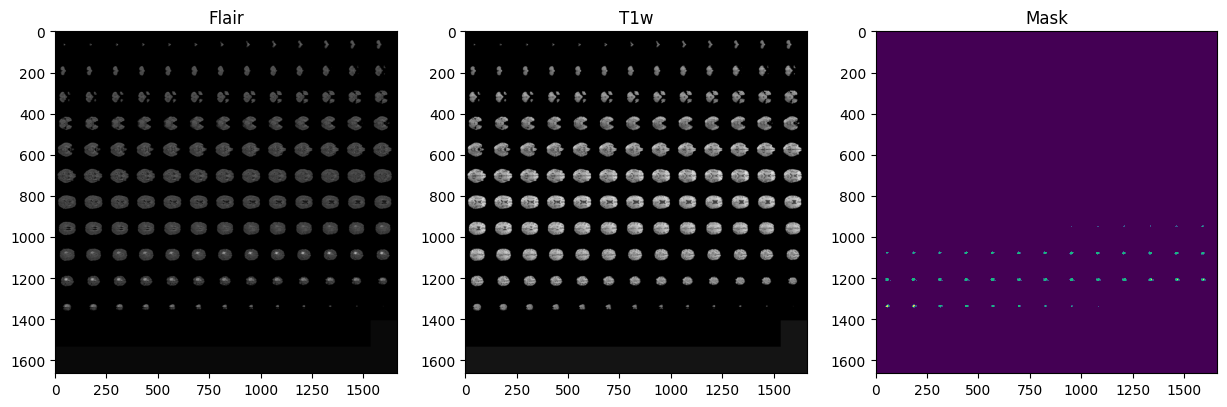

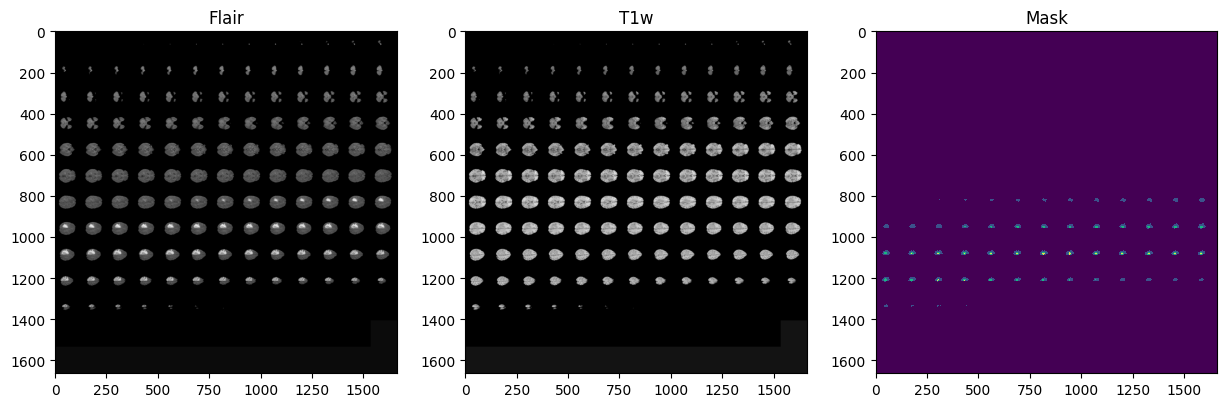

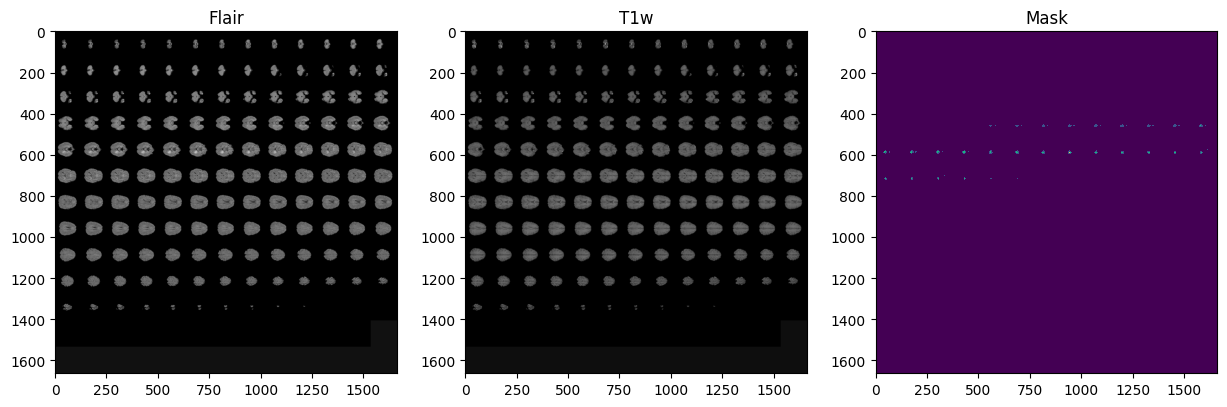

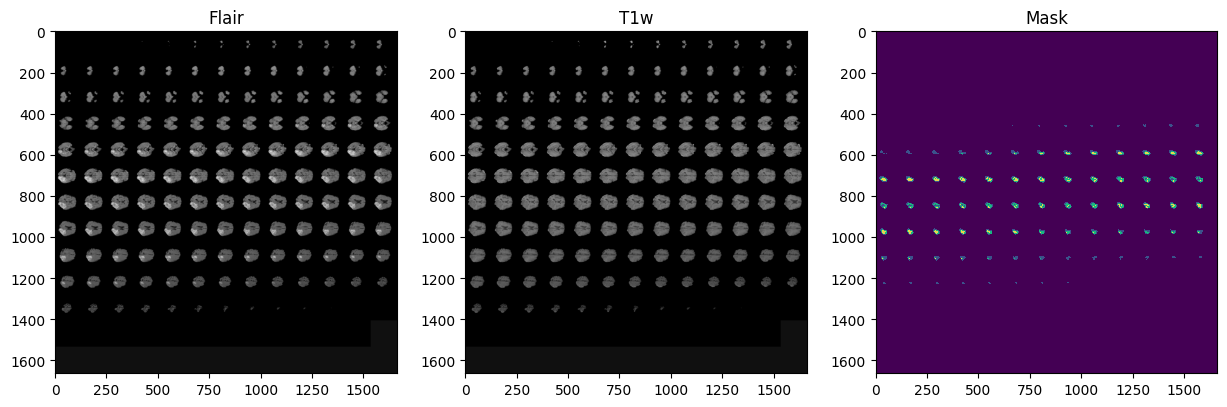

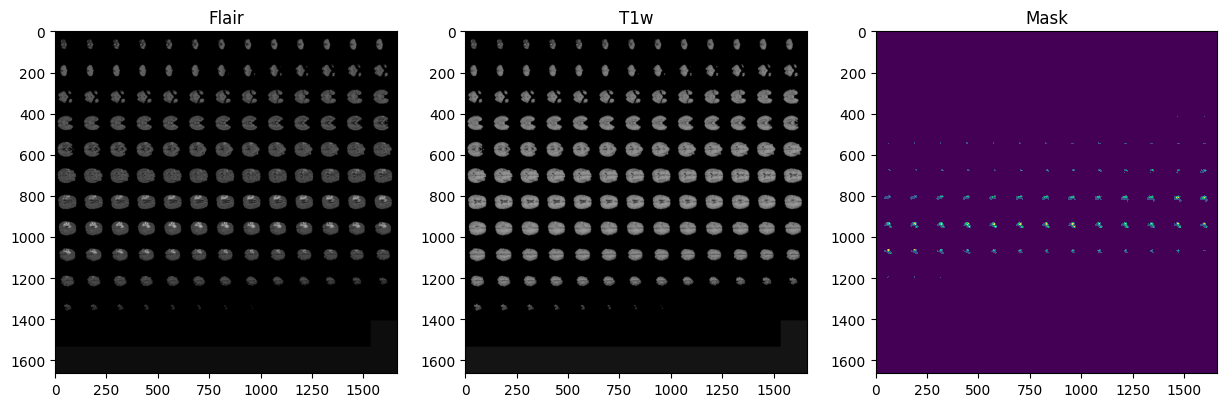

In [21]:
train_loader = data_module.train_dataloader()
val_loader = data_module.val_dataloader()
test_loader = data_module.test_dataloader()

for i, (X, y) in enumerate(train_loader):
    if i >= 5:
        break
    plt.figure(figsize=(15, 15))
    plt.subplot(1, 3, 1)
    plt.imshow(
        montage(X[0, :, :, :, 0]),
        cmap="gray",
    )
    plt.title("Flair")

    plt.subplot(1, 3, 2)
    plt.imshow(
        montage(X[0, :, :, :, 1]),
        cmap="gray",
    )
    plt.title("T1w")

    # Mask
    cmap = matplotlib.colors.ListedColormap(
        ["#440054", "#3b528b", "#18b880", "#e6d74f"]
    )
    norm = matplotlib.colors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], cmap.N)
    mask = y[0, :, 1, :, :] + 2 * y[0, :, 2, :, :] + 3 * y[0, :, 3, :, :]
    plt.subplot(1, 3, 3)
    plt.imshow(montage(mask[:, :, :]), cmap=cmap, norm=norm)
    plt.title("Mask")

    plt.show()